<a href="https://colab.research.google.com/github/AbbasRahimi/netgan/blob/testing/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
!git clone -b testing https://github.com/AbbasRahimi/netgan.git

In [ ]:
%cd netgan
#!pip install python-igraph


In [1]:

!pip install -r requirements.txt


You should consider upgrading via the 'c:\users\abbasrahimi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
#import tensorflow as tf
from netgan.netgan import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from netgan import utils
import scipy.sparse as sp
from netgan import graph_plotting
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/small_DS.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


(40, 40)
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


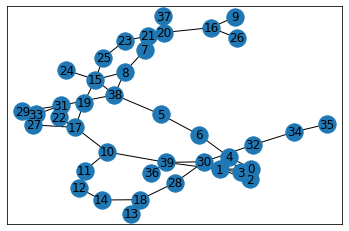

In [3]:
graph_plotting.plot_graph_from_sparse_matrix(_A_obs)
# print('A:', type(_A_obs), '\n', _A_obs)
# print('X:', type(_X_obs), '\n', _X_obs)
# print('z:', type(_z_obs), '\n', _z_obs)

In [4]:
val_share = 0.1
test_share = 0.05
#seed = 481516234

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [7]:
print(train_graph)

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 4)	1.0
  (1, 0)	1.0
  (1, 3)	1.0
  (1, 4)	1.0
  (1, 39)	1.0
  (2, 0)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (4, 1)	1.0
  (4, 6)	1.0
  (5, 6)	1.0
  (5, 38)	1.0
  (6, 4)	1.0
  (6, 5)	1.0
  (7, 8)	1.0
  (7, 20)	1.0
  (7, 21)	1.0
  (8, 7)	1.0
  (8, 38)	1.0
  (9, 16)	1.0
  (10, 11)	1.0
  (10, 39)	1.0
  (11, 10)	1.0
  :	:
  (29, 27)	1.0
  (29, 31)	1.0
  (30, 28)	1.0
  (30, 32)	1.0
  (30, 39)	1.0
  (31, 22)	1.0
  (31, 29)	1.0
  (31, 33)	1.0
  (31, 38)	1.0
  (32, 30)	1.0
  (32, 34)	1.0
  (33, 31)	1.0
  (34, 32)	1.0
  (34, 35)	1.0
  (35, 34)	1.0
  (36, 39)	1.0
  (37, 20)	1.0
  (38, 5)	1.0
  (38, 8)	1.0
  (38, 15)	1.0
  (38, 31)	1.0
  (39, 1)	1.0
  (39, 10)	1.0
  (39, 30)	1.0
  (39, 36)	1.0


#### Parameters

In [8]:
rw_len = 6
batch_size = 32

In [9]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [10]:
walker.walk().__next__()

array([[ 4,  1, 39, 30, 28, 18],
       [ 9, 16, 26, 16,  9, 16],
       [36, 39, 30, 32, 30, 32],
       [39, 30, 39, 36, 39, 36],
       [36, 39, 10, 39, 30, 32],
       [14, 18, 28, 18, 13, 18],
       [37, 20,  7,  8,  7, 20],
       [21, 20, 23, 20, 16,  9],
       [10, 11, 10, 11, 10, 11],
       [20, 16, 20, 37, 20, 21],
       [ 5, 38, 15, 38, 31, 29],
       [21, 20, 21, 20, 16, 20],
       [36, 39, 10, 39,  1,  4],
       [33, 31, 29, 31, 33, 31],
       [24, 15, 19, 15, 24, 15],
       [ 6,  5,  6,  4,  0,  2],
       [34, 32, 34, 32, 34, 35],
       [11, 10, 39, 10, 11, 10],
       [21,  7,  8, 38,  8, 38],
       [20, 21, 20, 23, 20, 37],
       [ 4,  1,  4,  0,  2,  0],
       [34, 35, 34, 32, 30, 28],
       [37, 20, 21, 20, 16, 26],
       [15, 24, 15, 25, 15, 25],
       [25, 23, 20, 23, 20, 37],
       [24, 15, 19, 15, 19, 15],
       [19, 15, 38, 31, 22, 31],
       [33, 31, 29, 31, 29, 31],
       [ 9, 16, 20, 23, 20, 23],
       [ 7, 20, 37, 20, 21, 20],
       [37

#### Create our NetGAN model

In [11]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=32,batch_size=32,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[10], discriminator_layers=[8], temp_start=5, learning_rate=0.03)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
this is output in generator_recurrent :  Tensor("Generator/add_4:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_9:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_14:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_19:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_24:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_29:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_4:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_9:0", shape=(32, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_14:0", sh

c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

#### Define the stopping criterion

In [12]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [14]:
eval_every = 100
plot_every = 100

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_12.ckpt ****
**** Initializing... ****
**** Done.           ****
this is output in generator_recurrent :  Tensor("Generator_2/add_4:0", shape=(30000, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_9:0", shape=(30000, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_14:0", shape=(30000, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_19:0", shape=(30000, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_24:0", shape=(30000, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_29:0", shape=(30000, 40), dtype=float32)
**** Starting training. ****
mat is equal:  (40, 40)
**** Iter 100    Val ROC 0.680, AP: 0.696, EO 0.160 ****
mat is equal:  (40, 40)
**** Iter 200    Val ROC 0.640, AP: 0.745, EO 0.280 ****
mat is equ

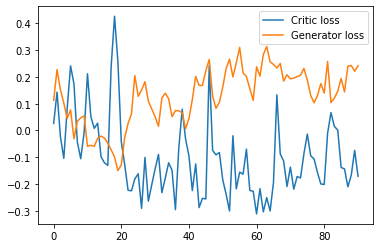

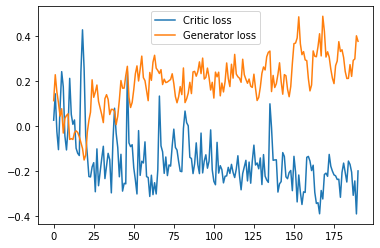

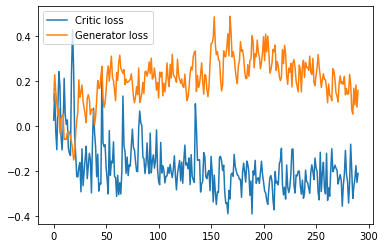

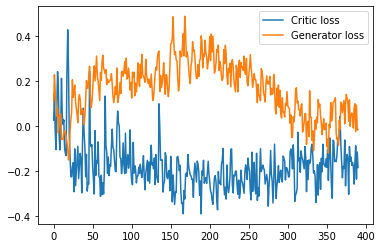

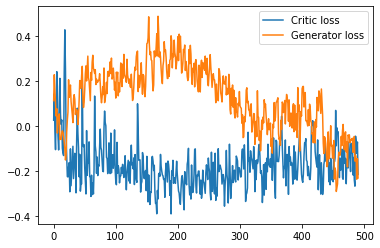

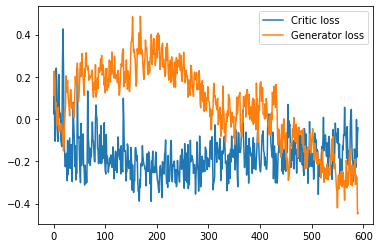

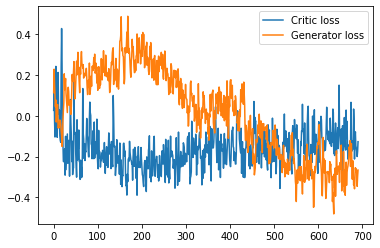

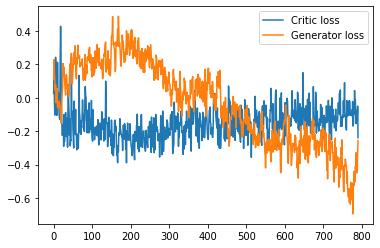

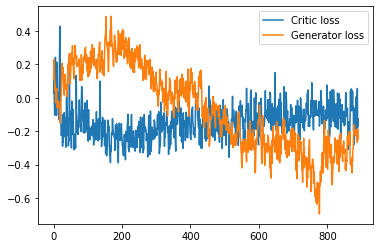

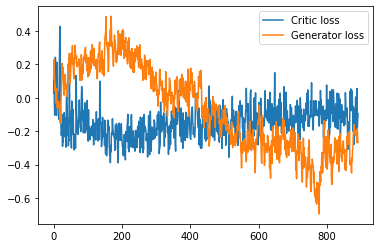

In [15]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=5, max_iters=1000)

In [16]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

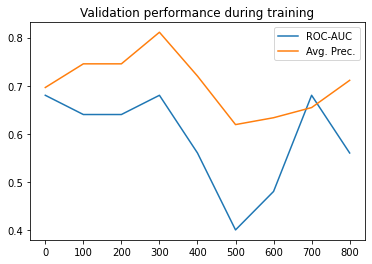

In [17]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

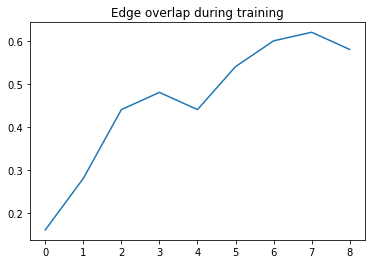

In [18]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [19]:
sample_many = netgan.generate_discrete(1200, reuse=True)

this is output in generator_recurrent :  Tensor("Generator_3/add_4:0", shape=(1200, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_9:0", shape=(1200, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_14:0", shape=(1200, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_19:0", shape=(1200, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_24:0", shape=(1200, 40), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_29:0", shape=(1200, 40), dtype=float32)


c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

In [20]:
samples = []

In [21]:
for _ in range(700):
    if (_+1) % 100 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

99
199
299
399
499
599
699


#### Assemble score matrix from the random walks

In [22]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()
# graph_plotting.plot_graph_from_sparse_matrix(scores_matrix)

mat is equal:  (40, 40)


generated_graph:  (40, 40)
scores_matrix:  (40, 40)
(40, 40)
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


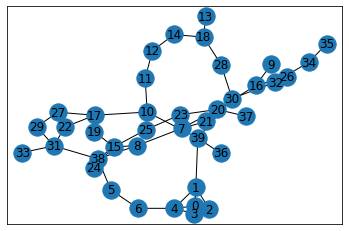

In [23]:
n_edges=50
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_plotting.plot_graph_from_sparse_matrix(_A_obs)

graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Edit distance between g1 and g2:  53.0
Edit distance between g1 and g2:  53.0


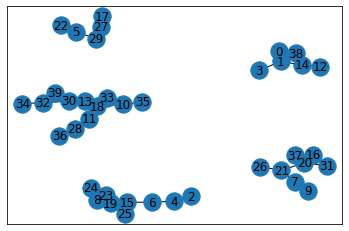

In [24]:
graph_plotting.plot_graph(generated_graph)
graph_plotting.graph_similarity(_A_obs,generated_graph,0, 0)

#### Evaluate generalization via link prediction

In [ ]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))
print("test_ones.T: ",test_ones.T)
print("len(test_ones): ",len(test_ones))
print("tuple(test_ones.T): ",tuple(test_ones.T))
print("tuple(test_zeros.T): ",tuple(test_zeros.T))
print("test_ones: ",scores_matrix[tuple(test_ones.T)])
print("test_ones: ",scores_matrix[tuple(test_zeros.T)])
print("test_ones.A1: ",scores_matrix[tuple(test_ones.T)].A1)
print("test_zeros.A1: ",scores_matrix[tuple(test_zeros.T)].A1)
print("test_labels : ",test_labels)
print("test_scores : ",test_scores)

roc_auc_score(test_labels, test_scores)

In [26]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))
print("test_ones.T: ",test_ones.T)
print("len(test_ones): ",len(test_ones))
print("tuple(test_ones.T): ",tuple(test_ones.T))
print("tuple(test_zeros.T): ",tuple(test_zeros.T))
print("test_ones: ",scores_matrix[tuple(test_ones.T)])
print("test_ones: ",scores_matrix[tuple(test_zeros.T)])
print("test_ones.A1: ",scores_matrix[tuple(test_ones.T)].A1)
print("test_zeros.A1: ",scores_matrix[tuple(test_zeros.T)].A1)
print("test_labels : ",test_labels)
print("test_scores : ",test_scores)

test_ones.T:  [[ 4  2 12  3  1 11]
 [ 3  1 11  4  2 12]]
len(test_ones):  6
tuple(test_ones.T):  (array([ 4,  2, 12,  3,  1, 11], dtype=int32), array([ 3,  1, 11,  4,  2, 12], dtype=int32))
tuple(test_zeros.T):  (array([19, 39, 32, 14, 32, 31]), array([14, 32, 31, 19, 39, 32]))
test_ones:  [[ 777. 5077.  782.  777. 5077.  782.]]
test_ones:  [[ 431. 3902.  889.  431. 3902.  889.]]
test_ones.A1:  [ 777. 5077.  782.  777. 5077.  782.]
test_zeros.A1:  [ 431. 3902.  889.  431. 3902.  889.]
test_labels :  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
test_scores :  [ 777. 5077.  782.  777. 5077.  782.  431. 3902.  889.  431. 3902.  889.]


In [23]:
roc_auc_score(test_labels, test_scores)

0.5555555555555556

In [24]:
average_precision_score(test_labels, test_scores)

0.7